ERROR! Session/line number was not unique in database. History logging moved to new session 5
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  4 of 4 completed
NaN in data! Fixed.
[[0.14726591 0.00740369 0.28348061 0.90560406]
 [0.14726591 0.00740369 0.28348061 0.90560406]
 [0.16287018 0.00718103 0.28348061 0.93958657]
 ...
 [0.77007934 0.87085282 0.16723317 0.74721776]
 [0.76770556 0.87096412 0.16723317 0.75616054]
 [0.76770556 0.87096412 0.17036029 0.75616054]]


array([[0.11504771],
       [0.11504771],
       [0.11997001],
       ...,
       [0.77007934],
       [0.77007934],
       [0.76770556]])

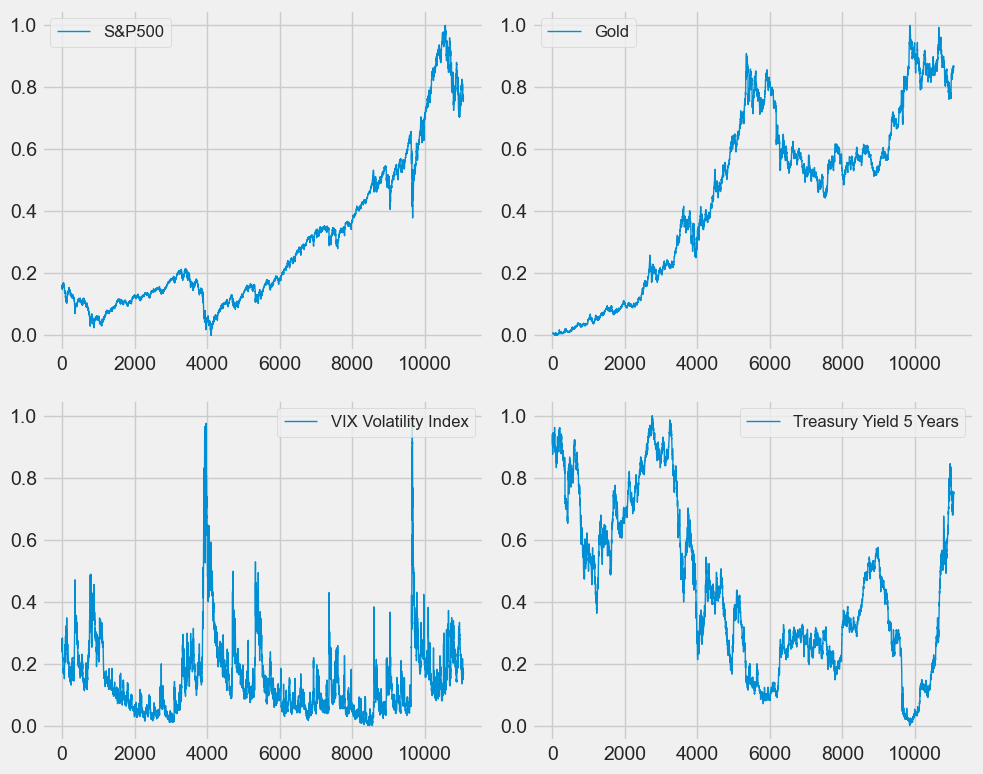

In [124]:
import sys
sys.path.insert(1, r"C:/Users/mihao/OneDrive - Univerza v Ljubljani/Doktorski_studij/Delo/Evolving transformer")
sys.path.insert(1, r"C:\Users\Miha\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\Evolving transformer")
from importlib import reload 
import data.dataclass as dataclass
reload(dataclass)

input_length = 100
output_length = 1
output_steps_ahead = 1
database = dataclass.StockData(input_length,output_length,output_steps_ahead)
database.display_data_norm()

#print(database.data_dropped)
print(database.data_norm)

#print(database.datasnp_dropped)
scalar = database.scalar

database.dataset_input
database.dataset_output


In [125]:

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class Stockdataset(Dataset):
    def __init__(self, data, input_length, output_length = 1):
        self.data = data
        self.data = torch.from_numpy(data).float()#.view(-1)
        self.seq_len = input_length
        self.out_len = output_length

    def __len__(self):
        return len(self.data)-(self.seq_len+self.out_len+1)

    def __getitem__(self, index):
        return self.data[index : index+self.seq_len], self.data[index+self.seq_len+1: index+self.seq_len+self.out_len+1,0]
        
size_training = int(len(database.data_norm)*0.95)
size_test = len(database.data_norm) - size_training
data_train, data_test = database.data_norm[0:size_training,:], database.data_norm[size_training:len(database.data_norm),:]

print(data_train.shape)
print(data_test.shape)

train_dataset = Stockdataset(data_train, input_length, output_length)
test_dataset = Stockdataset(data_test, input_length, output_length)
whole_dataset = Stockdataset(database.data_norm, input_length, output_length)

print(test_dataset.__getitem__(1)[0].shape)
print(train_dataset.__getitem__(1)[1].shape)
print(whole_dataset.__getitem__(0)[0].shape)


(10520, 4)
(554, 4)
torch.Size([100, 4])
torch.Size([1])
torch.Size([100, 4])


In [126]:
training_batch_size = 513
batch_size = training_batch_size
train_dataloader = DataLoader(train_dataset, batch_size, drop_last = True, shuffle=True) #drop_last = True ignores last batch is data is not divisable by batch_size
test_dataloader = DataLoader(test_dataset, batch_size, drop_last = True, shuffle=True)
whole_dataloader = DataLoader(whole_dataset, batch_size, drop_last = True, shuffle=False)
#whole_dataloader = DataLoader(train_dataset, 1, drop_last = False)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


cpu


In [127]:
import torch
from scipy.stats import multivariate_normal as mvn
class KMeansClusteringLoss(torch.nn.Module):
    def __init__(self):
        super(KMeansClusteringLoss, self).__init__()

    def forward(self, z, mu):
        length = z.shape[0]
        dim = z.shape[2]
        clusters = mu.shape[0]

        z = z.repeat(1,clusters,1)

        mu = mu.reshape(1, clusters, dim)
        mu = mu.repeat(length, 1, 1)

        dist_KM = (z-mu).norm(2, dim=2)
        
        loss_KM = torch.mean(dist_KM.min(dim=1)[0])
        
        return loss_KM
    
class FuzzyCMeansClusteringLoss(torch.nn.Module):
    def __init__(self):
        super(FuzzyCMeansClusteringLoss, self).__init__()

    def forward(self, z, mu, sigma_inv):
        length = z.shape[0]
        dim = z.shape[2]
        clusters = mu.shape[0]

        z = z.repeat(1,clusters,1)

        mu = mu.reshape(1, clusters, dim)
        mu = mu.repeat(length, 1, 1)

        d = torch.sub(z, mu)
        dl = d.reshape(length, clusters, 1, dim)
        sigma = torch.matmul(torch.exp(sigma_inv), (torch.transpose(torch.exp(sigma_inv), 2, 1)))
        d2_dS = torch.matmul(dl, sigma)
        dr = d.reshape(length, clusters, dim, 1)
        
        d2 = torch.matmul(d2_dS, dr).reshape(length, clusters,1)
        #d2 = torch.matmul(dl, dr).reshape(length, clusters,1)
        psi = torch.nn.functional.softmax(-d2,0).reshape(length, 1, clusters)
        #loss_FCM = torch.sum(torch.mul(psi, d2).min(dim=2)[0])
        
        dist_FCM = torch.mul(torch.pow(psi,3), torch.matmul(dl, dr).reshape(length, 1, clusters))
        loss_FCM = torch.sum(dist_FCM)
        
        dist_KM = (z-mu).norm(2, dim=2)
        
        loss_KM = dist_KM.min(dim=1)[0].sum()
        
        return loss_FCM
    
class LocalityPreservingLoss(torch.nn.Module):
    def __init__(self):
        super(LocalityPreservingLoss,self).__init__()
    
    def forward(self, x, z):
         
        loss = 0
        return loss
    
        
class QuadraticDiscriminantAnalysis(torch.nn.Module):
    def __init__(self):
        super(QuadraticDiscriminantAnalysis,self).__init__()
    
    def forward(self, z, mu, sigma_inv):
         
        length = z.shape[0]
        dim = z.shape[2]
        clusters = mu.shape[0]
        z = z.repeat(1,clusters,1)
        mu = mu.reshape(1,clusters,dim)
        mu = mu.repeat(length,1,1)
        d = torch.sub((mu),  z)
        dl = d.reshape(-1,clusters, 1, dim)
        dr = d.reshape(length, clusters, dim, 1)
        sigma = torch.matmul(torch.exp(sigma_inv), (torch.transpose(torch.exp(sigma_inv), 2, 1)))
        sigma_calc = torch.mean(torch.matmul(dr, dl),dim=0)
        d2_calc = torch.matmul(torch.matmul(dl, torch.linalg.inv(sigma_calc)), dr).reshape(length, clusters,1)
        d2_dS = torch.matmul(dl, sigma)
        d2 = torch.matmul(d2_dS, dr).reshape(length, clusters,1)

        
        loss_per_samle = torch.log(torch.det(sigma_calc))/2 + d2_calc.reshape(length, clusters)/2 - torch.log((1/clusters)*torch.ones(1,clusters).to(device))
        loss = torch.sum(loss_per_samle)
        #(psi*torch.log(psi)).reshape(length, clusters))
        
        return loss

class GaussianMixtureLoss(torch.nn.Module):
    def __init__(self):
        super(GaussianMixtureLoss,self).__init__()
    
    def forward(self, z, mu, S_inv):
         
        length = z.shape[0]
        dim = z.shape[2]
        clusters = mu.shape[0]
        z = z.repeat(1,clusters,1)
        mu = mu.reshape(1,clusters,dim)
        mu = mu.repeat(length,1,1)
        d = torch.sub((mu),  z)
        dl = d.reshape(-1,clusters, 1, dim)
        Sigma_inv = torch.matmul(torch.exp(S_inv), (torch.transpose(torch.exp(S_inv), 2, 1)))
        d2_dS = torch.matmul(dl, Sigma_inv)
        dr = d.reshape(length, clusters, dim, 1)
        d2 = torch.matmul(d2_dS, dr).reshape(length, clusters,1)
        psi = torch.nn.functional.softmax(-d2).reshape(length, 1, clusters)
        
        loss = torch.mean(torch.log(torch.det(torch.linalg.inv(Sigma_inv)))/2 + d2.reshape(length, clusters)/2)#to dela
        #loss = -torch.mean(like)
        ##(psi*torch.log(psi)).reshape(length, clusters))

        return loss
    
class OverlappingLoss(torch.nn.Module):
    def __init__(self):
        super(OverlappingLoss,self).__init__()

    def forward(self, mu, sigma_inv):
        dim = mu.shape[1]
        clusters = mu.shape[0]
        
        mu = mu.reshape(1, clusters, dim)
        sigma = torch.matmul(torch.exp(sigma_inv), (torch.transpose(torch.exp(sigma_inv), 2, 1)))
        d_B = torch.zeros(clusters,clusters)
        for i in range(clusters):
            for j in range(clusters):
                d_mu = mu[0,i]-mu[0,j]
                d_mu_t = d_mu.reshape(1, dim)
                sigma_ij = (sigma[i] + sigma[j])/2
                d_B[i,j] = (1/8)*torch.matmul(torch.matmul(d_mu_t,torch.inverse(sigma_ij)),d_mu) + (1/2)*torch.log(torch.det(sigma_ij)/torch.sqrt( torch.det(sigma[i])*torch.det(sigma[j]) ))
                
        loss_B = -torch.mean(d_B)
        return loss_B

In [128]:
class FuzzyCluster(torch.nn.Module):
    
    _EPS = 1e-12  # Value to use instead of 0 (to prevent div-by-zero)

    def __init__(self, n_c, n_in, m=1.7):
        super(FuzzyCluster, self).__init__()
        self.n_c = n_c
        self.n_in = n_in
        self.m = m
        self.centroids = torch.rand((self.n_c, self.n_in), dtype=dtype)
        self.last_u = None  # Record the most recent partition matrix

    @staticmethod
    def _cdist(x1, x2):
        x1_norm = x1.pow(2).sum(dim=-1, keepdim=True)
        x2_norm = x2.pow(2).sum(dim=-1, keepdim=True)
        # res = x2^2 -2(x1 @ x2) + x1^2
        res = torch.addmm(x2_norm.transpose(-2, -1),
                          x1, x2.transpose(-2, -1),
                          alpha=-2).add_(x1_norm)
        res = res.sqrt().clamp_min(FuzzyCluster._EPS)
        return res

    def recalc_centroids(self, x, u):

        um = u ** self.m
        # Batch multiply um by v:
        v = torch.einsum('mi,mj->ij', um, x)
        # Divide by u^m, summed by clusters:
        v /= um.sum(dim=0).clamp_min_(FuzzyCluster._EPS).unsqueeze(1)
        return v

    def forward(self, x):
        d = FuzzyCluster._cdist(x, self.centroids)
        u = d ** (- 2. / (self.m - 1))
        self.last_u = u / u.sum(dim=1, keepdim=True)
        return self.last_u


In [129]:
class AttentionDecoder(nn.Module):
  
  def __init__(self, hidden_size, output_size, vocab_size):
    super(AttentionDecoder, self).__init__()
    self.hidden_size = hidden_size
    self.output_size = output_size
    
    self.attn = nn.Linear(hidden_size + output_size, 1)
    self.lstm = nn.LSTM(hidden_size + vocab_size, output_size) #if we are using embedding hidden_size should be added with embedding of vocab size
    self.final = nn.Linear(output_size, vocab_size)
  
  def init_hidden(self):
    return (torch.zeros(1, 1, self.output_size),
      torch.zeros(1, 1, self.output_size))
  
  def forward(self, decoder_hidden, encoder_outputs, input):
    
    weights = []
    for i in range(len(encoder_outputs)):
      print(decoder_hidden[0][0].shape)
      print(encoder_outputs[0].shape)
      weights.append(self.attn(torch.cat((decoder_hidden[0][0], 
                                          encoder_outputs[i]), dim = 1)))
    normalized_weights =  torch.nn.functional.softmax(torch.cat(weights, 1), 1)
    
    attn_applied = torch.bmm(normalized_weights.unsqueeze(1),
                             encoder_outputs.view(1, -1, self.hidden_size))
    
    input_lstm = torch.cat((attn_applied[0], input[0]), dim = 1) #if we are using embedding, use embedding of input here instead
    
    output, hidden = self.lstm(input_lstm.unsqueeze(0), decoder_hidden)
    
    output = self.final(output[0])
    
    return output, hidden, normalized_weights

In [130]:
class FeedForward(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(FeedForward, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        output = self.l1(x) 
        #output = self.relu(output)
        output = self.l2(output)
        return output

In [131]:
class MultiheadSelfAttention(nn.Module):
        def __init__(self, input_length, cluster_dim, num_clusters, embed_dim, num_heads,num_layers):
                super(MultiheadSelfAttention, self).__init__()
                self.input_layer_norm = nn.LayerNorm(embed_dim)
                self.fc_att_emb = nn.Linear(embed_dim, 2*embed_dim) #output_length
                self.msa = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
                self.glu  = torch.nn.GLU()
                self.att_layer_norm = nn.LayerNorm(embed_dim)
                self.ff_ant = FeedForward(embed_dim, embed_dim, 10*embed_dim) #self.cluster_dim
                self.num_layers = num_layers
                self.ant_layer_norm = nn.LayerNorm(embed_dim)
                self.embed_dim = embed_dim
                self.flat = nn.Linear(embed_dim,1)
                self.fc_query = nn.Linear(embed_dim, embed_dim)
                self.fc_key = nn.Linear(embed_dim, embed_dim)
                
        def forward(self, x):
                input_dim = x.shape[2]
                #x = torch.transpose(x, 0, 1)
                
                #self.x_emb = torch.transpose(self.fc_att_emb(x),2,1)
                #query, key = self.x_emb.chunk(2, dim=-2)
                #x_att, weights = self.msa(query, key, x)

                query = self.fc_query(x)
                key = self.fc_key(x)#
                x_att, weights = self.msa(query, key, x)
                x_att = x_att + x#self.att_layer_norm(x_att + x)
                x_flat = self.flat(self.ff_ant(x_att) + x_att).transpose(2, 1)  #self.flat(self.ant_layer_norm(self.ff_ant(x_att) + x_att)).transpose(2, 1)      
                         
                x_glu = self.glu(x_flat.repeat(1,1,2))
                
                return x_flat, weights

In [132]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, input_length, cluster_dim, num_clusters):
        super(VariationalAutoencoder, self).__init__()
            #torch.randn(self.num_clusters, self.cluster_dim)
            #torch.rand(self.num_clusters, self.cluster_dim, self.cluster_dim)
        self.l_mu = nn.Linear(input_length, num_clusters*cluster_dim)
        self.l_sigma = nn.Linear(input_length, num_clusters*cluster_dim*cluster_dim)
        self.num_clusters = num_clusters
        self.cluster_dim = cluster_dim
        
    def forward(self, x):
        mu = self.l_mu(x).reshape(self.num_clusters, self.cluster_dim)
        sigma = self.l_sigma(x).reshape(self.num_clusters, self.cluster_dim, self.cluster_dim)
        return mu, sigma

In [133]:
from importlib import reload 
import compute_ellipse
reload(compute_ellipse)
from numpy.linalg import inv
import time
import pylab as pl
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns

class EvolvingSystem(nn.Module):
    def __init__(self, input_dim, output_dim, cluster_dim, num_clusters):
        super(EvolvingSystem, self).__init__()
        self.input_size = input_dim
        self.output_size = output_dim
        self.cluster_dim = cluster_dim
        self.num_clusters = num_clusters

        #self.etta = torch.nn.Parameter(data=torch.ones(1), requires_grad=True)
        self.mu = torch.nn.Parameter(data = 0.1*torch.rand(self.num_clusters,self.cluster_dim), requires_grad=True)
        self.sigma_inv = torch.nn.Parameter(data=(1*torch.rand(self.num_clusters,self.cluster_dim, self.cluster_dim)  + 
            	torch.diag_embed(4*torch.ones(self.num_clusters,self.cluster_dim))), requires_grad=True)
        
        #self.sigma_inv = torch.nn.Parameter(data=10*torch.rand(self.num_clusters,self.cluster_dim, self.cluster_dim), requires_grad=True)
        #self.sigma = torch.nn.Parameter(torch.matmul(self.sigma_inv, torch.transpose(self.sigma_inv, 2, 1)), requires_grad=True)
        #self.sigma_alpha = torch.nn.Parameter(data=torch.randn(self.num_clusters,self.cluster_dim), requires_grad=True)
        
        #self.fc_con = nn.Linear(input_length, output_length) #output_length
        self.fc_con = nn.Linear(regressor_dim, self.num_clusters*output_length) #output_length
        
        self.fc_recon = nn.Linear(regressor_dim, self.num_clusters*input_length) #output_length
        #self.fc_con = FeedForward(input_length, self.num_clusters, 20) #output_length
        #self.fc_recon = FeedForward(input_length, input_length*self.num_clusters, 1)
        #self.fc_con = FeedForward(input_length, self.num_clusters, input_length) #output_length
        #self.fc_recon = FeedForward(input_length, input_length*self.num_clusters, input_length)
        self.sm = torch.nn.Softmax(dim = 1)
        
        #self.evol_drop_layer = nn.Dropout(p=0.5)

    def compute_centers(self, z):
        psi = self.compute_psi(z)

        mu = torch.sum(torch.einsum('bmi, bmj->bji', psi, z),0)
        mu /= psi.sum(dim=0).clamp_min_(1e-30)
        
        return mu
    
    def compute_sigma(self, z):
        psi = self.compute_psi(z)

        d = torch.sub((self.mu),  z)
        dl = d.reshape(batch_size, self.num_clusters, 1, self.cluster_dim)
        dr = d.reshape(batch_size, self.num_clusters, self.cluster_dim, 1)
        S = torch.matmul(dr, torch.matmul( dl, sigma_inv))
        
        sigma = torch.sum(torch.einsum('bmi, bmkl->bkl', psi, S),0)
        sigma /= psi.sum(dim=0).clamp_min_(1e-30)
        
        return sigma
    
    def compute_psi(self, z):
        
        d = torch.sub((self.mu), z)
        dl = d.reshape(batch_size, self.num_clusters, 1, self.cluster_dim)
        
        #TEST OK -> self.mu-self.x_ant[0][0], d[0], dl[0]
        sigma_inv = torch.matmul((self.sigma_inv), torch.transpose((self.sigma_inv), 2, 1))

        d2_dS = torch.matmul(dl, sigma_inv)

        dr = d.reshape(batch_size, self.num_clusters, self.cluster_dim, 1)

        #d2 = torch.matmul(d2_dS, dr)
        d2 = torch.matmul(d2_dS, dr)
        #d2 = torch.pow(d2, torch.pow(self.etta, 2)
        psi = self.sm(-d2.reshape(batch_size, self.num_clusters,1))
        #psi = self.evol_drop_layer(psi)
        #TEST OK -> self.sm(-d2).reshape(batch_size,1,self.num_clusters)[0], self.sm(-d2)
        psi = psi.reshape(batch_size, 1, self.num_clusters).clamp_min(1e-15)
        return psi
    
    def forward(self, z, x):

        #self.x_ant = torch.cat((self.x_ant, u.reshape(batch_size,1,1)), dim = 2)
        self.psi = self.compute_psi(z)

        #x_con = x_con.repeat(1,self.num_clusters,1)
        y_con = self.fc_con(x) #.reshape(batch_size, -1, self.num_clusters) #.reshape(batch_size, output_length, self.num_clusters)
        y = torch.matmul(self.psi, torch.transpose(y_con,-1,-2))
        x_recon = self.fc_recon(x).reshape(batch_size, self.num_clusters, input_length)
        x_recon = torch.matmul(self.psi, x_recon)
        
        #print(torch.sum(psi[0]))
        #y = torch.transpose(y_con,-1,-2) #torch.matmul(self.psi, torch.transpose(y_con,-1,-2))
        #self.x_recon = torch.matmul(self.psi, torch.transpose(x_recon,1,0).reshape(input_length,batch_size,self.num_clusters, 1)).reshape(batch_size, 1, input_length)
        
        #final_out = self.fc(out)
        return y, x_recon

In [134]:

loss_fun_con = nn.MSELoss()
loss_fun_centers = nn.MSELoss()
loss_fun_recon = nn.MSELoss()
loss_fun_assign = torch.nn.KLDivLoss(size_average=None, reduce=None, reduction="sum", log_target=True) #vhodi morajo bit logaritmirani
loss_fun_balance = torch.nn.KLDivLoss(size_average=None, reduce=None, reduction="sum", log_target=True) #vhodi morajo bit logaritmirani
loss_fun_Kmeans = KMeansClusteringLoss()
loss_fun_local = LocalityPreservingLoss()
loss_fun_DQA = QuadraticDiscriminantAnalysis()
loss_fun_GMM = GaussianMixtureLoss()
loss_fun_FCM = FuzzyCMeansClusteringLoss()
loss_fun_overlap = OverlappingLoss()


from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture


In [135]:
class Lstm_model(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_size, num_layers):
        super(Lstm_model, self).__init__()
        self.num_layers = num_layers
        self.input_size = input_dim
        self.output_size = output_dim
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_size, num_layers=num_layers)
        self.fc = nn.Linear(input_dim, output_dim)
        self.evolve = EvolvingSystem(input_dim, output_dim, cluster_dim, num_clusters)
        self.MSA = MultiheadSelfAttention(input_length, cluster_dim, num_clusters, embed_dim, num_heads,num_layers)
        #self.VAE = VariationalAutoencoder(input_length, cluster_dim, num_clusters)
        #self.fc = EvolvingSystem(input_dim, output_dim, cluster_dim, num_clusters, hidden_size)
        self.fc_latent = FeedForward(input_length, cluster_dim, input_length) #self.cluster_dim
        self.fc_con = FeedForward(input_length, regressor_dim, input_length) #self.cluster_dim
        
    def forward(self, x, hn, cn):
        #self.en, (hn, cn) = self.lstm(x, (hn, cn))
        #self.en = self.fc(self.en).reshape(batch_size, 1,input_length)
        #self.att = self.MSA(self.en)   
        #x = self.fc(x).reshape(batch_size, 1,input_length)
        self.att, self.att_weights = self.MSA(x)
        self.z = self.fc_latent(self.att)
        self.u = self.att #self.fc_con(self.att)
        self.y, x_recon = self.evolve(self.z, self.u)
        #final_out = self.fc(out)
        return self.y, x_recon, hn, cn
    
    '''
    def predict(self, x):
        hn, cn = self.init()
        out = self.fc(out)
        final_out = self.evolve(out, x[-1,:,0])
        #final_out = self.fc(out)
        return final_out, hn, cn 
    '''
    
    def init(self):
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device) #zakaj je batch_size tako?
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device) #zakaj je treba to dodat tle?
        return h0, c0


In [136]:

num_heads = 4
cluster_dim = 2
num_clusters = 9
input_dim = 4
embed_dim = input_dim
output_dim = 1
hidden_size = 4
num_layers = 3
regressor_dim = 100

model = Lstm_model(input_dim, output_dim, hidden_size, num_layers).to(device)

#print(model.evolve.sigma_inv)
#print(model.evolve.mu)


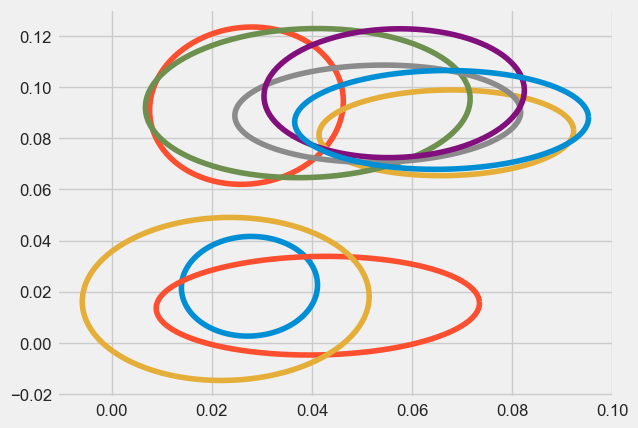

In [137]:
sigma_inv = model.evolve.sigma_inv
sigma_inv = torch.matmul(torch.exp(sigma_inv), torch.transpose(torch.exp(sigma_inv), 2, 1))
sigma = inv(sigma_inv.detach().cpu().numpy())[:,0:2,0:2]
mu = model.evolve.mu.detach().cpu().numpy()[:,0:2]
ellipse = compute_ellipse.Ellipse(sigma,mu,1)
ellipse_points = ellipse.confidence_ellipse()
ellipse_points = np.einsum('ijk->jik', ellipse_points)
plt.plot(ellipse_points[:,:,0],ellipse_points[:,:,1]) 
display.display(pl.gcf())   
display.clear_output(wait=True)
time.sleep(0.1)


In [138]:
def compute_distibution(d2):
    q_num = (1 + d2).pow_(-1)
    q_den = (1 + d2).pow_(-1).sum(2).reshape(-1,1,1)
    q = torch.div(q_num, q_den)
    p_num = torch.div(torch.pow(q, 2), torch.sum(q, 0))
    p_den = torch.sum(torch.div(torch.pow(q, 2), torch.sum(q, 0)),-1).reshape(-1,1,1)
    p = torch.div(p_num, p_den)
    return p

In [139]:

def train(dataloader, loss_name):
    hn, cn = model.init()
    model.train()
    #alpha = 0.5
    loss_sum = 0
    x_ant = np.empty((0,1,cluster_dim))    
     
    for batch, item in enumerate(dataloader):
        x, y = item
        x = x.to(device)
        y = y.to(device)
  
        if torch.isnan(x).any() == True:           
            print("ERROR training input data!")
        if torch.isnan(y).any() == True:           
            print("ERROR training output data!!")

        out, x_recon, hn, cn = model(x.reshape(batch_size, input_length, input_dim), hn, cn)
        
        if torch.isnan(out).any() == True:           
            print("ERROR Output!")
        if torch.isnan(x_recon).any() == True:           
            print("ERROR Decoder!")

        #mu_target = model.evolve.compute_centers(model.z).reshape(num_clusters,cluster_dim)
        #sigma_target = model.evolve.compute_sigma(model.z).reshape(num_clusters,cluster_dim,cluster_dim)
        
        loss = torch.zeros(1).to(device)
        loss_kmeans = loss_fun_Kmeans(model.z, model.evolve.mu)
        if torch.isnan(loss_kmeans) == True:           
            print("ERROR loss!")
        loss_FCM = loss_fun_FCM(model.z, model.evolve.mu, model.evolve.sigma_inv)

        #loss_GMM = loss_fun_GMM(model.z, model.evolve.mu, model.evolve.sigma_inv)       
        loss_con = loss_fun_con(out.reshape(batch_size, output_dim,-1), y.reshape(batch_size, output_dim,-1))
        
        if loss_name == 'all':
        
            #loss_mu = loss_fun_centers(mu_target, model.evolve.mu)
            #loss_sigma = loss_fun_sigma(sigma_target, model.evolve.mu)
            loss_DQA = loss_fun_DQA(model.z, model.evolve.mu, model.evolve.sigma_inv)
            #loss_GMM = loss_fun_GMM(model.z, model.evolve.mu, model.evolve.sigma_inv)
            #loss_assign = loss_fun_assign(torch.nn.functional.log_softmax(model.evolve.psi, -1), compute_distibution(model.evolve.d2.reshape(-1,1,num_clusters)))
            loss_recon = loss_fun_recon(x_recon, x[:,:,0].reshape(batch_size, 1, input_length))
            loss_ballance = loss_fun_balance(torch.nn.functional.log_softmax(1/num_clusters*torch.ones(1,num_clusters).to(device),dim=1), torch.softmax(model.evolve.compute_psi(model.z),1)/batch_size)
            #loss_psi = -torch.sum(1/torch.log(model.evolve.compute_psi(model.z)))/batch_size
            #loss_psi = -torch.sum(torch.log(model.evolve.compute_psi(model.z))/batch_size)
            loss_overlap = loss_fun_overlap(model.evolve.mu, model.evolve.sigma_inv)
            
            #loss = loss + loss_recon  + loss_centers
            loss = loss + loss_recon*1e4  + loss_con*1e4 + loss_kmeans*1e2 + loss_ballance  #loss_FCM*1e10
            #+ loss_FCM*1e10
        '''
        if loss_name == 'encoder':
        
            loss_centers = loss_fun_centers(mu,model.evolve.mu)
            #loss_GMM = loss_fun_GMM(model.z, model.evolve.mu, model.evolve.sigma_inv)
            #loss_assign = loss_fun_assign(torch.nn.functional.log_softmax(model.evolve.psi, -1), compute_distibution(model.evolve.d2.reshape(-1,1,num_clusters)))
            loss_recon = loss_fun_recon(x_recon, x[:,:,0].reshape(batch_size, 1, input_length))
            loss_ballance = loss_fun_balance(torch.nn.functional.log_softmax(1/num_clusters*torch.ones(1,num_clusters).to(device),dim=1), torch.sum(model.evolve.compute_psi(model.z),0)/batch_size)

            #loss = loss + loss_recon  + loss_centers
            loss = loss + loss_recon#  + loss_centers               

          
        if loss_name == "cluster":

            loss_FCM = loss_fun_FCM(model.z, model.evolve.mu, model.evolve.sigma_inv)

            #loss_ballance = loss_fun_balance(1/num_clusters*torch.ones(1,num_clusters).to(device), torch.log(torch.sum(model.evolve.psi,0)/batch_size))

            loss_GMM = loss_fun_GMM(model.z, model.evolve.mu, model.evolve.sigma_inv)
            loss_centers = loss_fun_centers(mu,model.evolve.mu)
            #loss = loss + loss_FCM + loss_centers
            loss = loss + loss_centers  + loss_kmeans   
            #breakpoint()
            if torch.isnan(loss) == True:           
                print(f"ERROR loss_clust {loss_clust}!")
                breakpoint()
'''


        if loss_name == 'output':
            loss = loss + loss_con
            
        loss_sum = loss_sum + loss.item()  
        if torch.isnan(loss) == True:           
            print("ERROR loss!")

        
        x_ant = np.append(x_ant, model.z.detach().cpu().numpy(),axis=0)
        hn = hn.detach() #detach hn is not a parameters and does not need to be updated!!!
        cn = cn.detach()
        optimizer.zero_grad()
        loss.backward()
        if torch.isnan(loss) == True:           
            print("ERROR loss!")
        optimizer.step()




        if torch.any(torch.isnan(model.evolve.mu)) == True:  
            print("ERROR mu!")

        if (batch == 1) | (batch == len(dataloader) -1):    
            #if loss_name == "output" and True:  
                #display.display(pl.gcf())  
            display.clear_output(wait=True)
            plt.plot(x_recon[0,:,:].detach().cpu().numpy().reshape(input_length, 1))
            plt.plot(x[0,:,0].detach().cpu().numpy().reshape(input_length, 1))  
            plt.show()  
                
            print(f"Train loss: {loss_sum:>7f}")
    return loss_sum, x_ant

In [140]:
class MultiheadSelfAttention(nn.Module):
        def __init__(self, input_length, cluster_dim, num_clusters, embed_dim, num_heads,num_layers):
                super(MultiheadSelfAttention, self).__init__()
                self.input_layer_norm = nn.LayerNorm(embed_dim)
                self.fc_att_emb = nn.Linear(embed_dim, 2*embed_dim) #output_length
                self.msa = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
                self.glu  = torch.nn.GLU()
                self.att_layer_norm = nn.LayerNorm(embed_dim)
                self.ff_ant = FeedForward(embed_dim, embed_dim, 10*embed_dim) #self.cluster_dim
                self.num_layers = num_layers
                self.ant_layer_norm = nn.LayerNorm(embed_dim)
                self.embed_dim = embed_dim
                self.flat = nn.Linear(embed_dim,1)
                self.fc_query = nn.Linear(embed_dim, embed_dim)
                self.fc_key = nn.Linear(embed_dim, embed_dim)
                
        def forward(self, x):
                input_dim = x.shape[2]
                #x = torch.transpose(x, 0, 1)
                
                #self.x_emb = torch.transpose(self.fc_att_emb(x),2,1)
                #query, key = self.x_emb.chunk(2, dim=-2)
                #x_att, weights = self.msa(query, key, x)

                query = self.fc_query(x)
                key = self.fc_key(x)#
                x_att, weights = self.msa(query, key, x)
                x_att = x_att + x#self.att_layer_norm(x_att + x)
                x_flat = self.flat(self.ff_ant(x_att) + x_att).transpose(2, 1)  #self.flat(self.ant_layer_norm(self.ff_ant(x_att) + x_att)).transpose(2, 1)      
                         
                x_glu = self.glu(x_flat.repeat(1,1,2))
                
                return x_glu, weights


'''
model.evolve.mu.grad
model.evolve.sigma_inv.grad
model.evolve.msa.in_proj_weight.grad
model.evolve.msa.in_proj_bias.grad
model.evolve.msa.out_proj.weight.grad
model.evolve.msa.out_proj.bias.grad
model.evolve.fc_ant.weight.grad
model.evolve.fc_ant.bias.grad
model.evolve.fc_con.weight.grad
model.evolve.fc_con.bias.grad
model.evolve.fc_emb.weight.grad
model.evolve.fc_emb.bias.grad
model.evolve.input_layer_norm.weight.grad
model.evolve.input_layer_norm.bias.grad
model.evolve.ant_norm.weight.grad
model.evolve.ant_norm.bias.grad
'''

In [141]:
def test(dataloader):
    hn, cn = model.init()
    loss_sum = 0
    for batch, item in enumerate(dataloader):
        x, y = item
        x = x.to(device)
        y = y.to(device)
        out, x_recon, hn, cn = model(x.reshape(input_length, batch_size, input_dim), hn, cn)
        loss = loss_fun_con(out.reshape(batch_size, output_dim,-1), y.reshape(batch_size, output_dim,-1))
        loss_sum = loss_sum + loss.item()
        if batch == len(dataloader) -1:
            #loss = loss.item()
            print(f"Test loss: {loss_sum:>7f}")   
    return loss_sum
            

In [142]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

lstm.weight_ih_l0 tensor([[-0.3401, -0.3984,  0.0825,  0.0839],
        [ 0.4954, -0.3841, -0.0370, -0.4578],
        [ 0.4180,  0.3003, -0.3277,  0.2840],
        [-0.3009, -0.1151, -0.3679,  0.1906],
        [ 0.0494, -0.2815, -0.0236,  0.0916],
        [-0.2545,  0.4362,  0.4022, -0.0174],
        [ 0.4279, -0.2266, -0.1464, -0.2202],
        [-0.0460, -0.2432,  0.3671,  0.2203],
        [ 0.3655,  0.1897,  0.3785, -0.0495],
        [-0.2662, -0.4040,  0.4420, -0.0666],
        [-0.1296, -0.3835, -0.0429, -0.4682],
        [-0.3592,  0.1083, -0.2574,  0.0103],
        [ 0.2485,  0.0025,  0.0719,  0.4027],
        [ 0.4838, -0.2050,  0.4820, -0.1630],
        [ 0.4117,  0.2358, -0.0730,  0.3834],
        [-0.1314, -0.1954,  0.0508,  0.4660]])
lstm.weight_hh_l0 tensor([[-0.0844, -0.1471, -0.2056,  0.1103],
        [ 0.3075, -0.0581,  0.4066,  0.0445],
        [ 0.3481,  0.0712,  0.0207,  0.4348],
        [ 0.0964,  0.3058, -0.1389, -0.2415],
        [-0.0982,  0.4632, -0.4606,  0.4415

In [143]:
def compute_GK(z, mu, sigma_inv):
    
    length = z.shape[0]
    dim = z.shape[2]
    clusters = mu.shape[0]

    z = torch.Tensor(z).repeat(1,clusters,1).to(device)

    mu = mu.reshape(1,clusters,dim)
    mu = mu.repeat(length,1,1)

    d = torch.sub((mu),  z)
    dl = d.reshape(-1,clusters, 1, dim)
    sigma = torch.matmul(torch.exp(sigma_inv), torch.transpose(torch.exp(sigma_inv), 2, 1))
    d2_dS = torch.matmul(dl, sigma)
    dr = d.reshape(length, clusters, dim, 1)
    
    d2 = torch.matmul(d2_dS, dr).reshape(length, clusters,1)
    #d2 = torch.matmul(dl, dr).reshape(length, clusters,1)
    psi = torch.nn.functional.softmax(-d2,1).reshape(length,clusters,1).repeat(1,1,dim)
    psi_sigma = psi.reshape(length,clusters,dim,1).repeat(1,1,1,dim)
    
    mu_out = torch.zeros(clusters,dim)
    #sigm_out = torch.zeros(clusters,dim,dim)
    for i in range(clusters):
        mu_out[i,:] = torch.div(sum(torch.mul(psi[:,i,:],z[:,i,:])),sum(psi[:,i,:])[0])
        #sigm_out[i,:,:]  = torch.div(sum(torch.mul(psi_sigma[:,i,:,:],torch.matmul(dr,d2_dS)[:,i,:,:])),sum(psi[:,i,:])[0])
    
    return mu_out

In [144]:
from matplotlib.pyplot import cm
from matplotlib.cm import get_cmap
def display_clustering(sigma_inv, mu, z):
        #display.display(pl.gcf())
        clusters = mu.shape[0]
        display.clear_output(wait=True) 
        sigma_inv = torch.matmul(torch.exp(sigma_inv), torch.transpose(torch.exp(sigma_inv), 2, 1))
        sigma = inv(sigma_inv.detach().cpu().numpy())
        nc_plot = mu.shape[0]
        sigma = sigma[0:nc_plot,0:2,0:2]
        mu = mu.detach().cpu().numpy()
        mu = mu[0:nc_plot,0:2]
        ellipse = compute_ellipse.Ellipse(sigma,mu,1)
        ellipse_points = ellipse.confidence_ellipse()
        ellipse_points = np.einsum('ijk->jik', ellipse_points)
        plt.plot(ellipse_points[:,:,0],ellipse_points[:,:,1])
        #color = iter(cm.rainbow(np.linspace(0, 1, clusters)))
        #for i in range(clusters):
        #        c = next(color)
        #        plt.plot(ellipse_points[:,i,0],ellipse_points[:,i,1], c=c)
        
def display_membership(psi, z):
        #display.display(pl.gcf())   
        for i in range(num_clusters):
                index = np.argmax(psi,2) == i
                plt.plot(z[index,0], z[index,1],'.') #color=plt.cm.RdYlBu(i))
                #plt.plot(z[index,0], z[index,1],'.', color = plt.gca().lines[i+1].get_color()) #color=plt.cm.RdYlBu(i))
        plt.show()  
        
def display_attention(att):
        im = plt.imshow(att)
        plt.colorbar(im)
        plt.show()


In [146]:
%matplotlib inline
best_model = float('inf')
#plt.ioff()
train_iterations = 10000
batch_size = training_batch_size
for i in range(train_iterations):


    for p in model.parameters():
        p.requires_grad = True 


    loss_name = "all"
    lr = 1e-3
    epochs = 100
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)    
    for epoch in range(epochs): 
           
        print(f"Epoch {epoch} - " + loss_name)
        loss_train_encoder, _ = train(train_dataloader,loss_name)
        
        if (np.mod(epoch,1) == 0):
            plt.show()    
            #display_clustering(model.evolve.sigma_inv, model.evolve.mu, model.z.detach().cpu().numpy())
            #mu = model.evolve.compute_centers(model.z).detach().cpu().numpy()
            #plt.plot(mu[0,:], mu[1,:], 'or')
            display_membership(model.evolve.compute_psi(model.z).detach().cpu().numpy(), model.z.detach().cpu().numpy())
            display_attention(model.att_weights[0,:,:].detach().cpu().numpy())
            #plt.plot(torch.mean(model.att_weights[0,:,:],0).detach().cpu().numpy())
            #plt.show()
    for p in model.parameters():
        p.requires_grad = True 

    for name, param  in model.named_parameters():
        if "evolve.mu" == name:
            param.requires_grad = False
        if "evolve.sigma_inv" == name:
            param.requires_grad = False
    
    loss_name = "encoder"
    lr = 1e-6
    epochs = 0
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)    
    for epoch in range(epochs): 
           
        print(f"Epoch {epoch} - " + loss_name)
        loss_train_encoder, _ = train(train_dataloader,loss_name)
        
        #display_clustering(model.evolve.sigma_inv, model.evolve.mu, model.z.detach().cpu().numpy())
        #mu = model.evolve.compute_centers(model.z).detach().cpu().numpy()
        #plt.plot(mu[0,:], mu[1,:], 'or')
        #
        display_membership(model.evolve.compute_psi(model.z).detach().cpu().numpy(), model.z.detach().cpu().numpy())
        display_attention(model.att_weights[0,:,:].detach().cpu().numpy())

    for p in model.parameters():
        p.requires_grad = False 
    for name, param  in model.named_parameters():
        if "evolve.mu" == name:
            param.requires_grad = True
        if "evolve.sigma_inv" == name:
            param.requires_grad = True
    
    '''
    with torch.no_grad():
        gmm = BayesianGaussianMixture(n_components=num_clusters, covariance_type='full', init_params="k-means++").fit(x_ant_train.reshape(-1,cluster_dim))
        #mu = Gaus'sianMixture(x_ant_train, model.evolve.mu, model.evolve.sigma_inv)
        u, s, v  = torch.linalg.svd(torch.from_numpy(gmm.covariances_), full_matrices=True)
        s_sqrt = torch.diag_embed(torch.sqrt(s))
        sigma_inv = torch.linalg.inv(torch.matmul(s_sqrt, v))
        mu = torch.from_numpy(gmm.means_)
        for name, param in model.named_parameters():
            if 'evolve.mu' == name:
                param.copy_(mu)
            if 'evolve.sigma_inv' == name:
                param.copy_(sigma_inv) 
       
    #GMM_clusters = GaussianMixture(num_clusters, sparsity=20)
    epochs = 0
    loss_name = "cluster"
    lr = 1e-5
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)    
    for epoch in range(epochs): 
           
        print(f"Epoch {epoch} - " + loss_name)
        loss_train_cluster, z_ant_train = train(train_dataloader,loss_name)
                    
        display_clustering(model.evolve.sigma_inv, model.evolve.mu, model.z.detach().cpu().numpy())
        mu = model.evolve.compute_centers(model.z).detach().cpu().numpy()
        plt.plot(mu[0,:], mu[1,:], 'or')
        display_membership(model.evolve.compute_psi(model.z).detach().cpu().numpy(), model.z.detach().cpu().numpy())
        #plt.show()
    '''   
    '''     
    for p in model.parameters():
        p.requires_grad = True 
        
    loss_name = "output"    
    
    lr = 1e-3
    epochs = 0
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)    
    for epoch in range(epochs): 
        print(f"Epoch {epoch} - " + loss_name)
        loss_train_output, _ = train(train_dataloader,loss_name)
    '''    
    loss_test = test(test_dataloader)
    if (best_model > loss_train_encoder):
        best_model = loss_train_encoder
        torch.save(model, "model_evolve_cluster.pt")
        print(f"Save model loss: {loss_test} - ")
    
    #display_clustering(model.evolve.sigma_inv, model.evolve.mu, z_ant_train)
    #plt.show()    


Epoch 0 - all


In [ ]:
loss_test = test(test_dataloader)
if (best_model > loss_train_encoder):
    best_model = loss_train_encoder
    torch.save(model, "model_evolve_cluster_05_18.pt")

: 

In [ ]:
import math
from sklearn.metrics import mean_squared_error
import numpy as np
def calculate_metrics(dataloader):
    pred_arr = []
    y_arr = []
    with torch.no_grad():
        hn, cn = model.init()
        for batch, item in enumerate(dataloader):
            x, y = item
            x, y = x.to(device), y.to(device)
            x = x.view(input_length, batch_size, input_dim)
            pred = model(x, hn, cn)
            pred = pred.view(batch_size, -1,1)
            pred = np.repeat(pred.detach().cpu().numpy(),input_dim,axis=2)
            pred = scalar.inverse_transform(pred)[:,0]
            y = np.repeat(y.detach().cpu().numpy(),input_dim,axis=1)
            y = scalar.inverse_transform(y)[:,0]
            pred_arr = pred_arr + list(pred)
            y_arr = y_arr + list(y)

        return math.sqrt(mean_squared_error(y_arr,pred_arr))



: 

In [ ]:
from torchsummary import summary

#print(model.evolve.fc_con.bias)
#print(model.evolve.fc_con.weight)
#print(model.evolve.sigma_inv)
#print(model.evolve.mu)

#summary(model,[(input_length, 1, input_dim),(num_layers, 1, hidden_size),(num_layers, 1, hidden_size)])
model = torch.load("model_evolve_cluster.pt")

#model.load_state_dict(torch.load("model_evolve_cluster.pt"))

model.eval()


: 

In [ ]:

#print(f"Train MSE loss {calculate_metrics(train_dataloader)}")
#print(f"Test MSE loss {calculate_metrics(test_dataloader)}")

: 

In [ ]:
def simulate(dataloader):
    pred_arr = []
    y_arr = []
    x_ant = np.empty((0,1,cluster_dim))
    model.eval()
    with torch.no_grad():
        (hn, cn) = model.init()
        for batch, item in enumerate(dataloader):
            x, y = item
            x, y = x.to(device), y.to(device)
            #pred,hn,cn = model(x.reshape(input_length, batch_size, input_dim), hn, cn)#[0]
            #pred = model.predict(x.reshape(input_length, batch_size, input_dim))[0]
            pred, x_pred, hn, cn = model(x.reshape(input_length, batch_size, input_dim), hn, cn)
            pred = pred.detach().cpu().numpy().reshape(1,-1)
            #pred = pred.view(1, output_length)
            #pred = np.repeat(pred.detach().cpu().numpy(),input_dim,axis=1)
            #pred = scalar.inverse_transform(pred)[:,0].reshape(-1)
            #y = np.repeat(y.detach().cpu().numpy().reshape(-1,1),input_dim,axis=1)
            #y = scalar.inverse_transform(y)[:,0].reshape(-1)
            y = y.detach().cpu().numpy()
            #plt.plot(np.linspace(1,input_length, input_length), x[0,:,0].detach().cpu().numpy())
            #plt.plot(np.linspace(input_length+1,input_length+output_length, 100),y[0,:].reshape(-1))
            #plt.plot(np.linspace(input_length+1,input_length+output_length, 100),pred[0,:].reshape(-1))
            #plt.show()
            pred_arr = pred_arr + list(pred.reshape(-1))
            y_arr = y_arr + list(y.reshape(-1))
            x_ant = np.append(x_ant, model.z.detach().cpu().numpy(),axis=0)
            
    return pred_arr, y_arr, x_ant
    
whole_pred_arr, whole_y_arr, x_ant  = simulate(whole_dataloader)



: 

In [ ]:
import matplotlib.pyplot as plt
fig1, axes1 = plt.subplots(figsize = (15, 10))
axes1.plot(whole_y_arr, linewidth=0.5)
axes1.plot(whole_pred_arr, linewidth=0.5)
fig1.savefig("model_evolve_cluster.pdf")


: 

In [ ]:
from importlib import reload 
import compute_ellipse
reload(compute_ellipse)
from numpy.linalg import inv
'''
sigma_inv = model.evolve.sigma_inv
sigma_inv = torch.matmul(torch.log(sigma_inv), torch.transpose(torch.log(sigma_inv), 2, 1))
sigma = inv(sigma_inv.detach().cpu().numpy())
nc_plot = num_clusters
sigma = sigma[0:nc_plot,0:2,0:2]
mu = torch.log(model.evolve.mu).detach().cpu().numpy()
mu = mu[0:nc_plot,0:2]
ellipse = compute_ellipse.Ellipse(sigma,mu,1)
ellipse_points = ellipse.confidence_ellipse()
ellipse_points = np.einsum('ijk->jik', ellipse_points)
plt.plot(x_ant_train[:,0,0],x_ant_train[:,0,1],'.k')
plt.plot(ellipse_points[:,:,0],ellipse_points[:,:,1])
plt.show()
'''   
'''
sigma_inv = model.evolve.sigma_inv
sigma_inv = torch.matmul(sigma_inv, torch.transpose(sigma_inv, 2, 1))
sigma = inv(sigma_inv.detach().cpu().numpy())

nc_plot = num_clusters
sigma = sigma[0:nc_plot,0:2,0:2]
mu = model.evolve.mu.detach().cpu().numpy()
mu = mu[0:nc_plot,0:2]

ellipse = compute_ellipse.Ellipse(sigma,mu,1)
ellipse_points = ellipse.confidence_ellipse()
ellipse_points = np.einsum('ijk->jik', ellipse_points)
plt.plot(x_ant[:,0,0],x_ant[:,0,1],'.k')
plt.plot(x_ant_train[:,0,0],x_ant_train[:,0,1],'.m')
plt.plot(ellipse_points[:,:,0],ellipse_points[:,:,1])
plt.show()  
'''
plt.plot(x_ant[:,0,0],x_ant[:,0,1],'.m')
display_clustering(model.evolve.sigma_inv, model.evolve.mu, model.z.detach().cpu().numpy())   



: 

In [ ]:
history -g


: 

In [ ]:
'''
%matplotlib inline
import time
import pylab as pl
from IPython import display
#fig2, axes2 = plt.subplots(figsize = (5, 3), linewidth=0.5)
#line1, = axes2.plot(np.zeros(output_length))
#line2, = axes2.plot(np.zeros(output_length))

import matplotlib.pyplot as plt
import time

def simulate(dataloader):
    pred_arr = []
    y_arr = []
    with torch.no_grad():
        hn, cn = model.init()
        for batch, item in enumerate(dataloader):
            x, y = item
            x, y = x.to(device), y.to(device)
            pred,hn,cn = model(x.reshape(input_length, batch_size, input_dim), hn, cn) #[0]
            pred = pred.detach().cpu().numpy().reshape(-1,1)
            #pred = pred.view(1, output_length)
            #pred = np.repeat(pred.detach().cpu().numpy(),input_dim,axis=1)
            #pred = scalar.inverse_transform(pred)[:,0].reshape(-1)
            #y = np.repeat(y.detach().cpu().numpy().reshape(-1,1),input_dim,axis=1)
            #y = scalar.inverse_transform(y)[:,0].reshape(-1)
            y = y.detach().cpu().numpy().reshape(-1,1)
            pred_arr = np.append( pred_arr, pred)
            y_arr = np.append(y_arr, y)

            
            #axes2.cla()  
            #line1.set_ydata(pred_arr)
            #line2.set_ydata(y_arr)
            plt.plot(pred_arr,'b')
            plt.plot(y_arr,'r')
            #fig2.tight_layout()
            #fig2.show()

            display.display(pl.gcf())   
            display.clear_output(wait=True)
            time.sleep(0.1)
            
    return pred_arr, y_arr

batch_size = 1
whole_pred_arr, whole_y_arr = simulate(whole_dataloader)
'''

: 